**EECE 7150 AUTONOMOUS FIELD ROBOTICS**

**Homework 2**

**- Tejasri Kasturi**

**09/16/2024**

**Part 1:  Computing the Homography Matrix**

In [41]:
%matplotlib qt

The goal of the first part of the assignment is to replace the picture in image1 (which shows a picture on a wall) with image2. To achieve this, we compute the homography matrix H that transforms the four corners of image2 to the corresponding four corners of the picture in image1.

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [43]:
# Load image1 (the wall with the picture) and image2 (the picture to be replaced)
image1 = cv2.imread('E:\AFR\HW2\image1.jpg')  
image2 = cv2.imread('E:\AFR\HW2\image2.jpg')  

# Convert images from BGR to RGB for plotting
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)


**Image 1:**
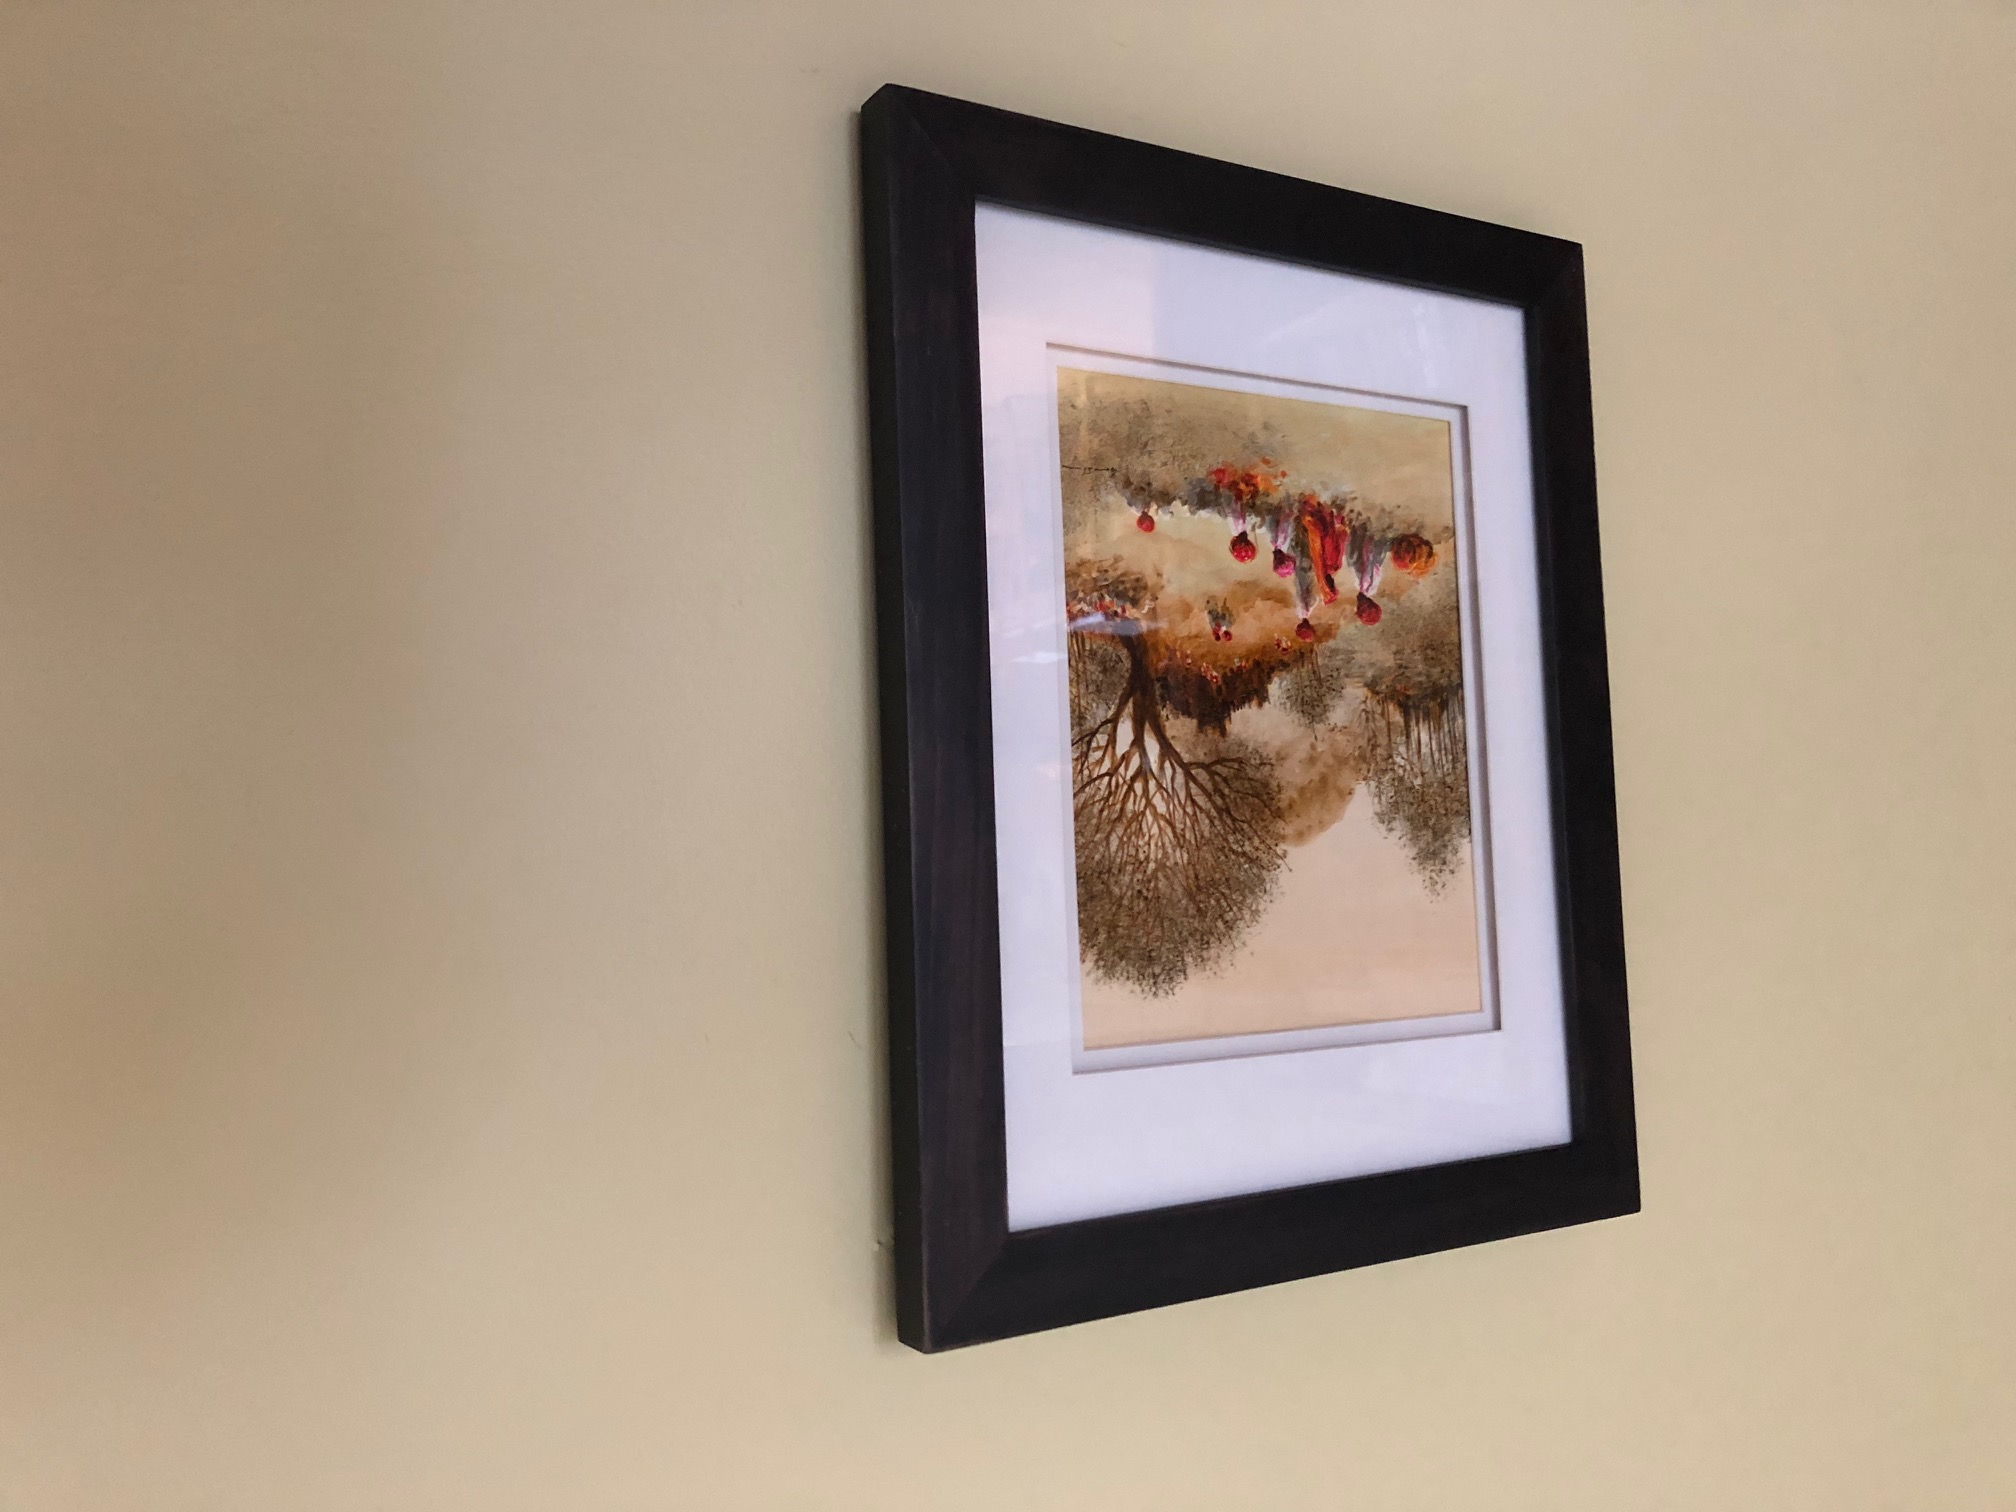


**Image 2:**
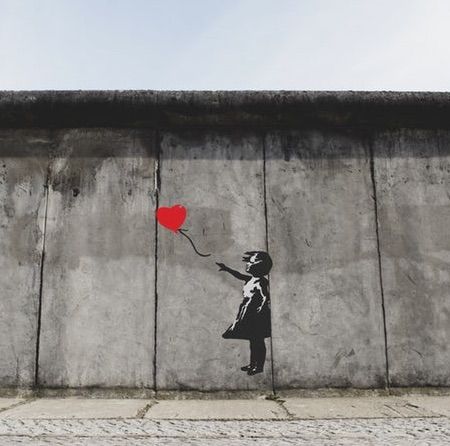

In [44]:
# Display image1 and select four corners
plt.figure(figsize=(10, 8))
plt.imshow(image1_rgb)
plt.title('Select four corners in image1 (clockwise)')
pts_image1 = plt.ginput(4)
plt.close()

# Display image2 and select four corners
plt.figure(figsize=(10, 8))
plt.imshow(image2_rgb)
plt.title('Select four corners in image2 (clockwise)')
pts_image2 = plt.ginput(4)
plt.close()

# Convert points to NumPy arrays
pts_image1 = np.array(pts_image1, dtype='float32')
pts_image2 = np.array(pts_image2, dtype='float32')


In [45]:
def compute_homography(pts_src, pts_dst):
    A = []
    for i in range(pts_src.shape[0]):
        x, y = pts_src[i][0], pts_src[i][1]
        u, v = pts_dst[i][0], pts_dst[i][1]
        A.append([-x, -y, -1, 0, 0, 0, u*x, u*y, u])
        A.append([0, 0, 0, -x, -y, -1, v*x, v*y, v])
    A = np.array(A)
    # Compute SVD
    U, S, Vh = np.linalg.svd(A)
    # Homography is the last column of V (or last row of Vh)
    H = Vh[-1].reshape((3, 3))
    # Normalize
    H = H / H[-1, -1]
    return H

H = compute_homography(pts_image2, pts_image1)
print("Homography Matrix H:\n", H)


Homography Matrix H:
 [[ 5.72020121e-01  1.26788764e-01  5.29617728e+02]
 [-2.60139716e-01  1.41404743e+00  4.93771040e+02]
 [-3.41597980e-04  7.27531682e-05  1.00000000e+00]]


Homography transformations allow us to project one image onto another, even when the two images are captured from different perspectives.

In [46]:
# Warp image2 to the perspective of image1
warped_image2 = cv2.warpPerspective(image2, H, (image1.shape[1], image1.shape[0]))

# Create a mask for blending
mask = warped_image2 > 0

# Replace the region in image1 with warped image2
image1[mask] = warped_image2[mask]

# Convert back to RGB for displaying
result_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(result_rgb)
plt.title('Image1 with Image2 Mapped onto It')
plt.axis('off')
plt.show()


**Final output of mapping image 2 on to image 2 with 4 point selection:**


![Img1_2(4pt).png](attachment:Img1_2(4pt).png)



**Part 2: Additional Corresponding Points for an Overconstrained Homography**


In this part, we expanded the number of points used to compute the homography from 4 to 8 points. The goal was to recompute the homography matrix in an over-constrained situation and observe the differences in the transformation.

In [58]:
# Load images
image1 = cv2.imread('E:\AFR\HW2\image1.jpg')  # The wall with the picture
image2 = cv2.imread('E:\AFR\HW2\image2.jpg')  # The picture to replace
image3 = cv2.imread('E:\AFR\HW2\car_img3.webp')  # The new image to map onto image1

# Check if images are loaded
if image1 is None or image2 is None or image3 is None:
    raise IOError("One or more images couldn't be loaded. Check the file paths.")

# Convert images from BGR to RGB for visualization
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image3_rgb = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)


**Image 3(New_Image)**

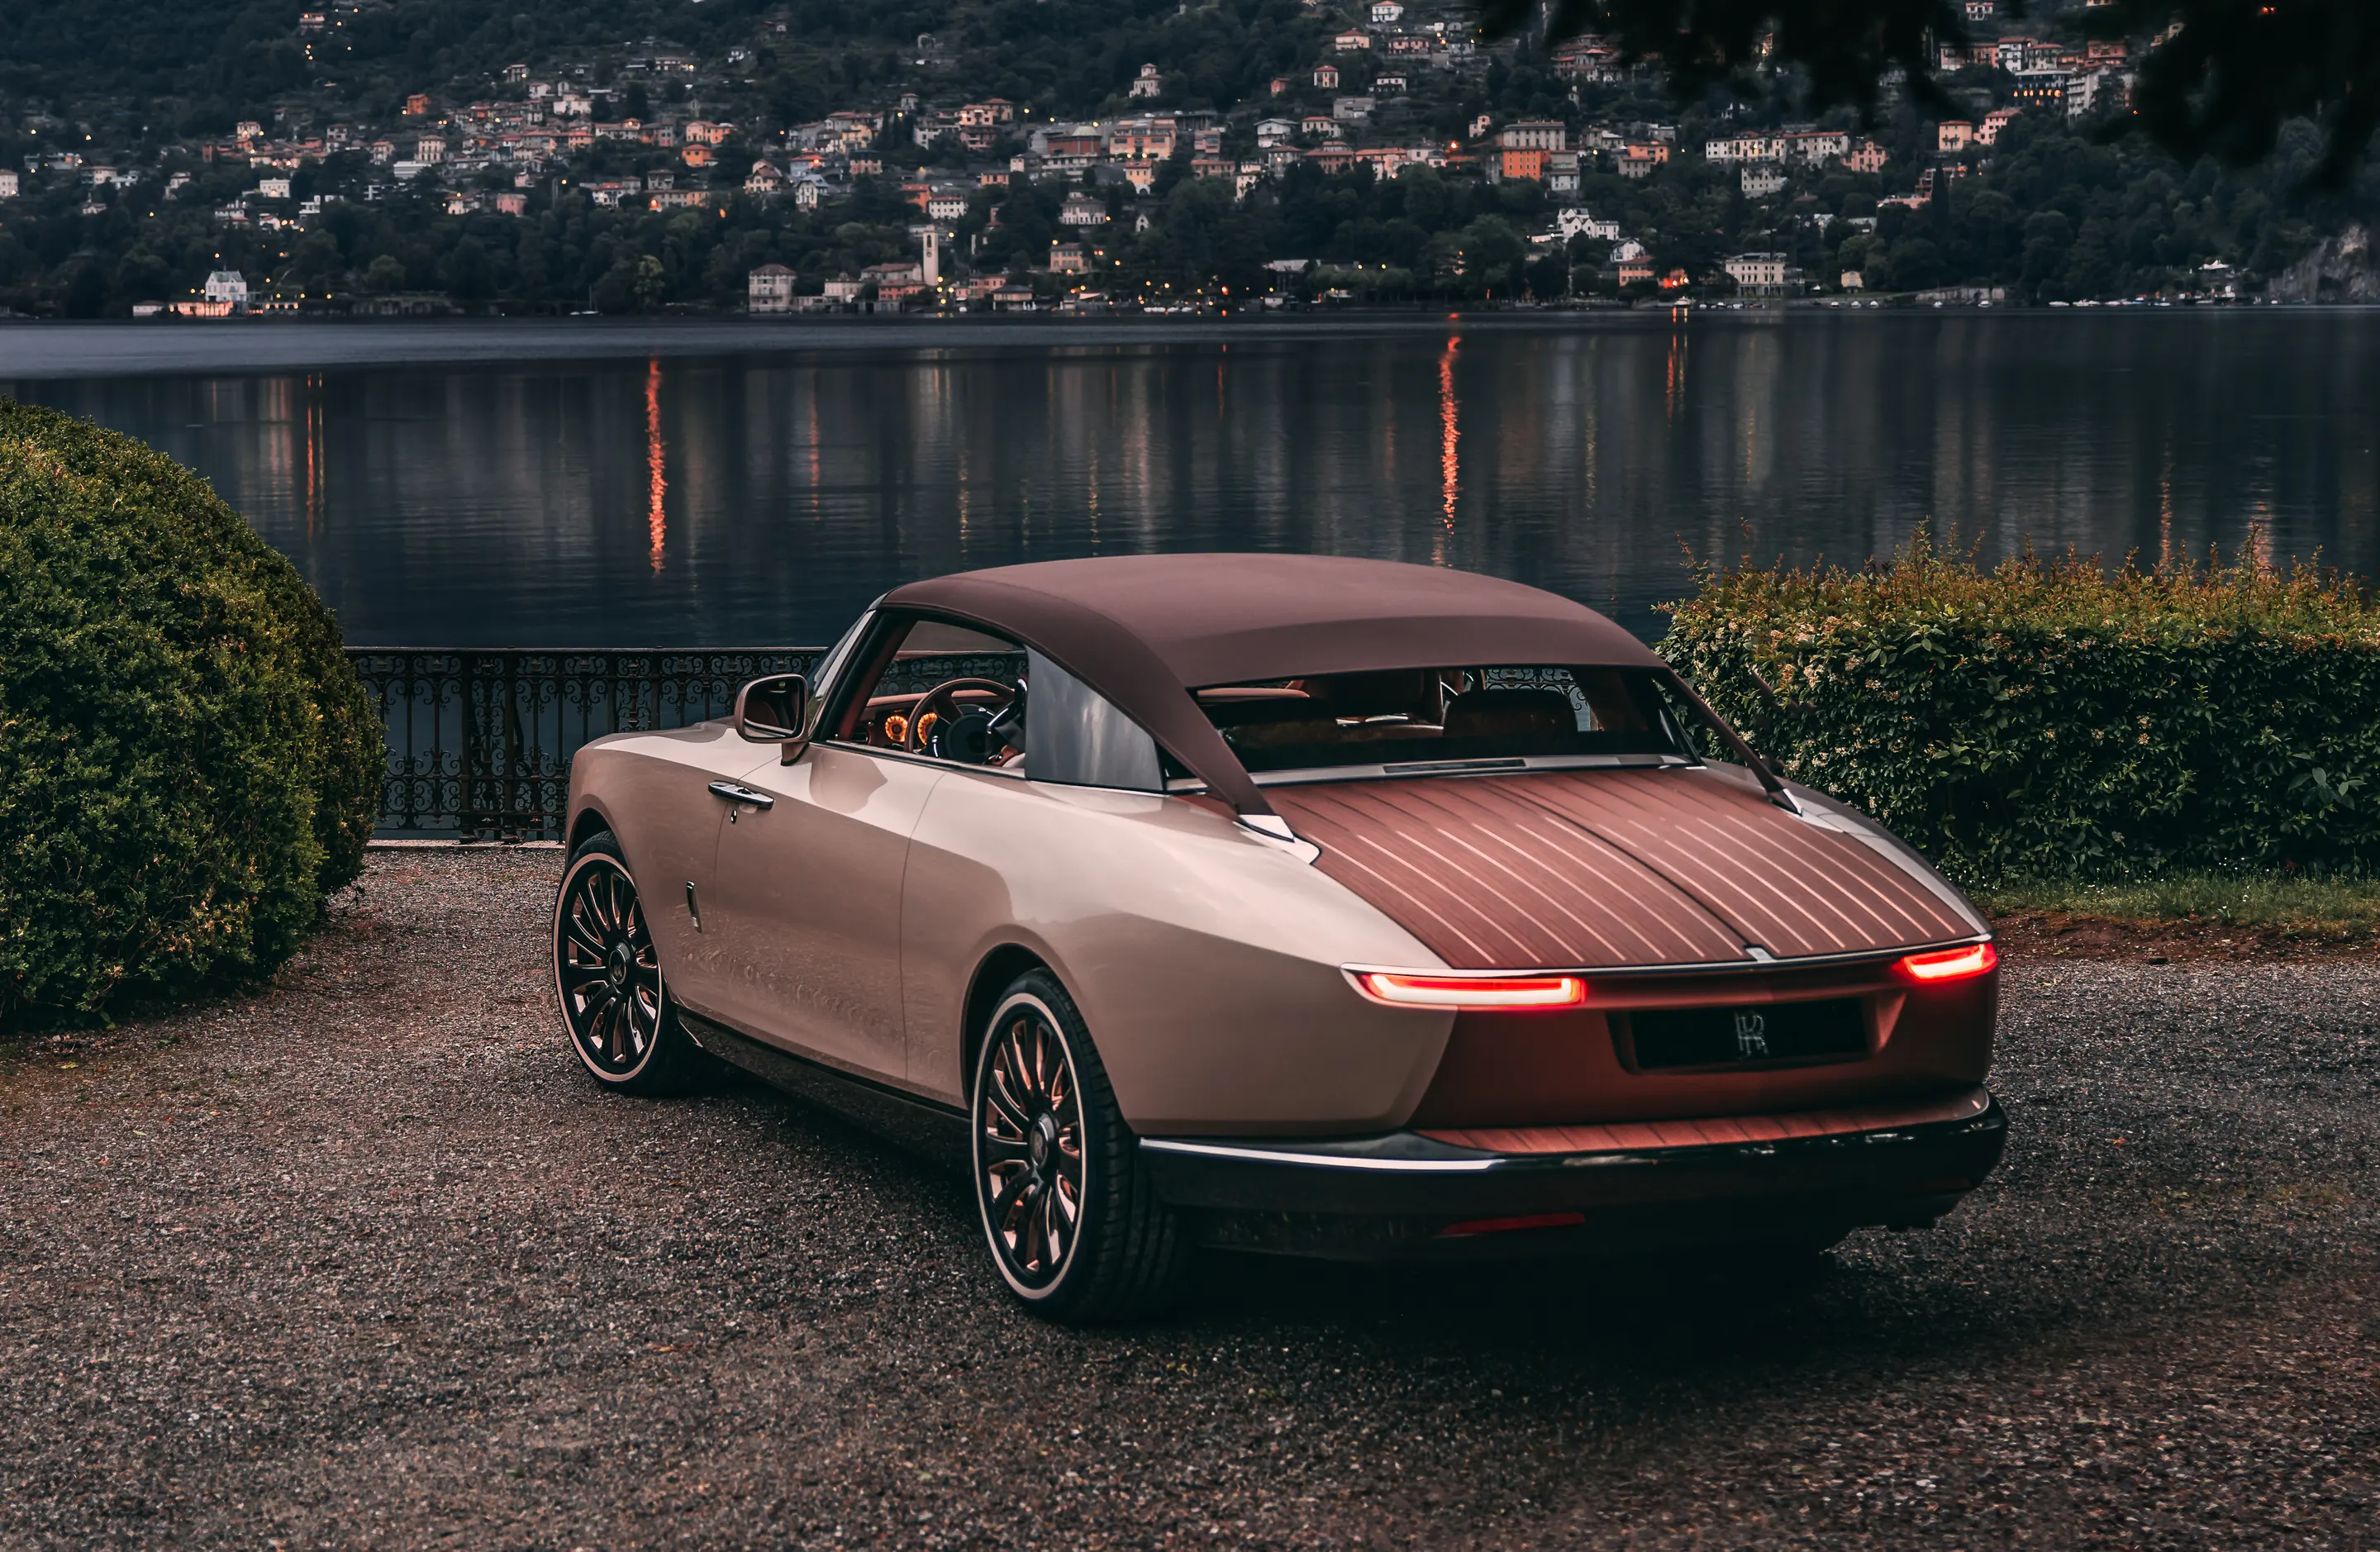

In [59]:
# Function to select points using matplotlib's ginput
def select_points(image, title='Select points'):
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title(title)
    points = plt.ginput(8, timeout=0)  # Selecting 8 points
    plt.close()
    return np.array(points, dtype='float32')

# Select eight points in image1
pts_image1 = select_points(image1_rgb, 'Select eight points in Image1 (four original + four additional)')

# Select corresponding eight points in image2
pts_image2 = select_points(image2_rgb, 'Select corresponding eight points in Image2 (four original + four additional)')

# Verify the number of points selected
assert pts_image1.shape[0] == 8 and pts_image2.shape[0] == 8, "Eight points must be selected in each image."


In [60]:
def compute_homography_least_squares(pts_src, pts_dst):
    """
    Computes the homography matrix using Direct Linear Transformation (DLT) with least squares.
    
    Parameters:
    - pts_src: Source points (from the source image).
    - pts_dst: Destination points (in the destination image).
    
    Returns:
    - H: 3x3 Homography matrix.
    """
    A = []
    for i in range(pts_src.shape[0]):
        x, y = pts_src[i][0], pts_src[i][1]
        u, v = pts_dst[i][0], pts_dst[i][1]
        A.append([-x, -y, -1,  0,  0,  0, u*x, u*y, u])
        A.append([ 0,  0,  0, -x, -y, -1, v*x, v*y, v])
    A = np.array(A)
    
    # Perform SVD
    U, S, Vh = np.linalg.svd(A)
    # Homography is the last column of V (or last row of Vh)
    H = Vh[-1].reshape((3, 3))
    # Normalize
    H = H / H[-1, -1]
    return H

# Compute the homography matrix using eight points
H_over = compute_homography_least_squares(pts_image2, pts_image1)
print("Over-Constrained Homography Matrix H_over:\n", H_over)


Over-Constrained Homography Matrix H_over:
 [[ 5.80830715e-01  6.47902306e-02  5.36197787e+02]
 [-2.49052709e-01  1.33765738e+00  5.00072231e+02]
 [-3.14719828e-04  6.62839955e-06  1.00000000e+00]]


In [61]:
# Warp image2 onto image1 using H_over
warped_image2 = cv2.warpPerspective(image2, H_over, (image1.shape[1], image1.shape[0]))

# Create a mask where warped_image2 has non-zero pixels
mask2 = warped_image2 > 0

# Replace the region in image1 with warped_image2
image1_modified = image1.copy()
image1_modified[mask2] = warped_image2[mask2]

# Convert to RGB for displaying
result2_rgb = cv2.cvtColor(image1_modified, cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(result2_rgb)
plt.title('Image1 with Image2 Mapped Onto It (8 point selection)')
plt.axis('off')
plt.show()


**Image2 Mapped Onto Image 1 (8 point selection)**


![img1_2(8pt)-2.png](attachment:img1_2(8pt)-2.png)


After recomputing the homography using 8 points, we observed some changes in the alignment accuracy. The additional points improved the robustness of the transformation, particularly in areas where the images were slightly misaligned using just 4 points.

In [62]:
# Step 6.1: Resize image3 to match image2's size
height2, width2 = image2.shape[:2]
image3_resized = cv2.resize(image3, (width2, height2))

# Convert resized image3 to RGB for visualization (optional)
image3_resized_rgb = cv2.cvtColor(image3_resized, cv2.COLOR_BGR2RGB)

# Step 6.2: Warp the resized image3 using H_over
warped_image3 = cv2.warpPerspective(image3_resized, H_over, (image1.shape[1], image1.shape[0]))

# Step 6.3: Create a mask for warped_image3
# Convert to grayscale and threshold to create a binary mask
gray_warped3 = cv2.cvtColor(warped_image3, cv2.COLOR_BGR2GRAY)
_, mask3 = cv2.threshold(gray_warped3, 1, 255, cv2.THRESH_BINARY)

# Step 6.4: Invert the mask to blackout the area in image1 where image3 will be placed
mask3_inv = cv2.bitwise_not(mask3)

# Step 6.5: Black-out the area of image3 in image1
image1_background = cv2.bitwise_and(image1, image1, mask=mask3_inv)

# Step 6.6: Take only the warped image3 region
image3_foreground = cv2.bitwise_and(warped_image3, warped_image3, mask=mask3)

# Step 6.7: Combine the background and the foreground
result_image3 = cv2.add(image1_background, image3_foreground)

# Convert to RGB for displaying
result3_rgb = cv2.cvtColor(result_image3, cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(result3_rgb)
plt.title('Image1 with Image3 Mapped Onto It')
plt.axis('off')
plt.show()

# Optional: Save the result
cv2.imwrite('image3_mapped.jpg', result_image3)


True

**New image mapped onto image 1 using new Homography matrix**
![Img1_3(over-constraint).png](attachment:Img1_3(over-constraint).png)

Using 8 points provided a more stable and accurate transformation, particularly for complex shapes or images with irregular distortions. The 4-point homography was sufficient for simpler transformations but was more prone to errors when the images had larger distortions.

**Part 3: Creating a Mosaic by Stitching Multiple Images**

The final task was to create a mosaic by stitching multiple images together using homographies. We took five overlapping images and hand-picked four points common across consecutive images to compute the homographies.

In [33]:
# Function to compute homography matrix using RANSAC
def compute_homography(src_pts, dst_pts):
    H, status = cv2.findHomography(src_pts, dst_pts, method=cv2.RANSAC)
    return H

# Function to blend two images using weighted averaging
def blend_images_weighted(img1, img2, mask):
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    # Expand the 2D mask into 3 channels
    mask_3d = np.dstack([mask] * 3)  # Now mask_3d has shape (height, width, 3)

    # Accumulate the pixel values from both images based on the mask
    mosaic_float = img1 * (1 - mask_3d) + img2 * mask_3d

    return np.clip(mosaic_float, 0, 255).astype(np.uint8)

In [34]:
# Function to automatically crop black borders from the stitched image
def crop_black_borders(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        cropped_image = image[y:y+h, x:x+w]
        return cropped_image
    return image

# Function to stitch two images using homography and blend them
def stitch_images(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    
    # Warp img2 to img1's perspective
    warped_img2 = cv2.warpPerspective(img2, H, (w1 + w2, max(h1, h2)))
    
    # Create a canvas for the stitched image
    canvas = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    canvas[0:h1, 0:w1] = img1
    
    # Create a mask to blend the images smoothly
    gray_warped = cv2.cvtColor(warped_img2, cv2.COLOR_BGR2GRAY)
    mask = (gray_warped > 0).astype(np.float32)  # 2D mask, with values 0 or 1

    # Blend the two images using weighted average
    blended_image = blend_images_weighted(canvas, warped_img2, mask)
    
    return blended_image

In [35]:
# Function to select points on an image manually
def select_points(image, num_points=4, title="Select The Points To Stitch :"):
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    points = plt.ginput(num_points, timeout=0)
    plt.close()

    if len(points) != num_points:
        raise ValueError(f"Expected {num_points} points, but got {len(points)}.")
    
    return np.array(points, dtype=np.float32)

In [36]:
# Function to stitch all images together
def stitch_all_images(images):
    mosaic = images[0]

    for i in range(1, len(images)):
        while True:  # Add a loop to allow re-stitching if user wants to reselect points
            print(f"Stitching image {i+1} to the mosaic...")

            # Select corresponding points between current mosaic and the next image
            src_pts = select_points(mosaic, title=f"Select points in mosaic (Image {i})")
            dst_pts = select_points(images[i], title=f"Select points in image {i+1}")

            # Compute homography
            H = compute_homography(dst_pts, src_pts)

            # Print the computed homography matrix
            print(f"Homography matrix for image {i+1} to mosaic:\n{H}\n")

            # Stitch the next image
            mosaic_temp = stitch_images(mosaic, images[i], H)

            # Display the stitched result to the user
            display_image(mosaic_temp, title=f"Stitched Image After Adding Image {i+1}")

            # Ask the user if the stitching result is acceptable
            confirmation = input("Are you satisfied with this stitch? (yes to proceed, no to reselect points): ").strip().lower()

            if confirmation == 'yes':
                mosaic = mosaic_temp  # Confirm the stitch and update the mosaic
                break  # Exit the loop and move on to the next image

    final_mosaic = crop_black_borders(mosaic)
    return final_mosaic

Image 1:
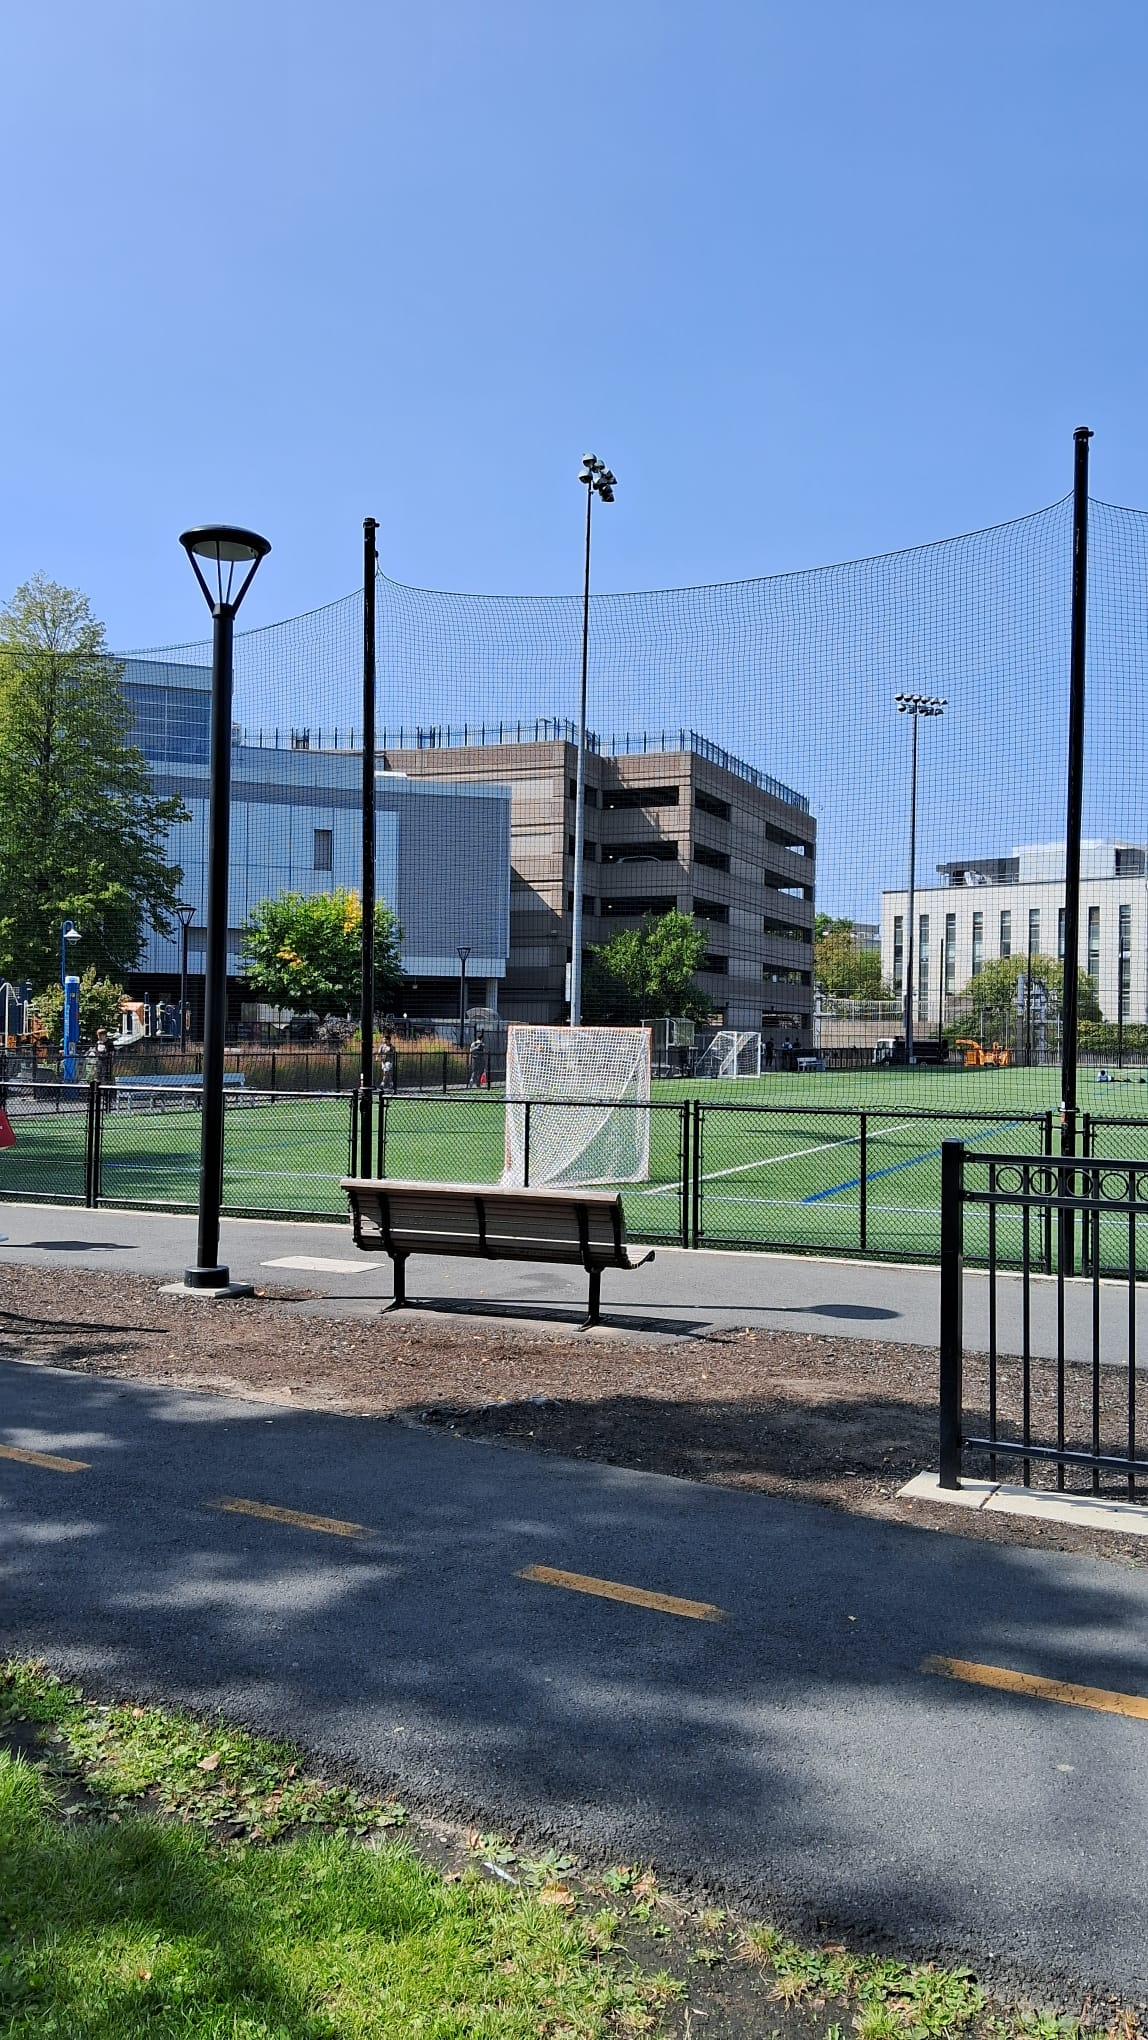

Image after consecutive stitching:

![Screenshot 2024-09-16 230525.png](<attachment:Screenshot 2024-09-16 230525.png>) ![Screenshot 2024-09-16 231114.png](<attachment:Screenshot 2024-09-16 231114.png>) ![Screenshot 2024-09-16 231426.png](<attachment:Screenshot 2024-09-16 231426.png>)
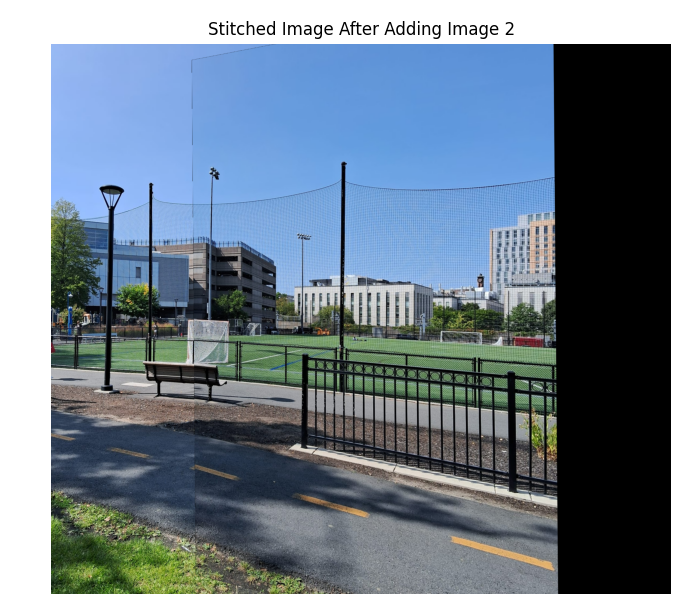
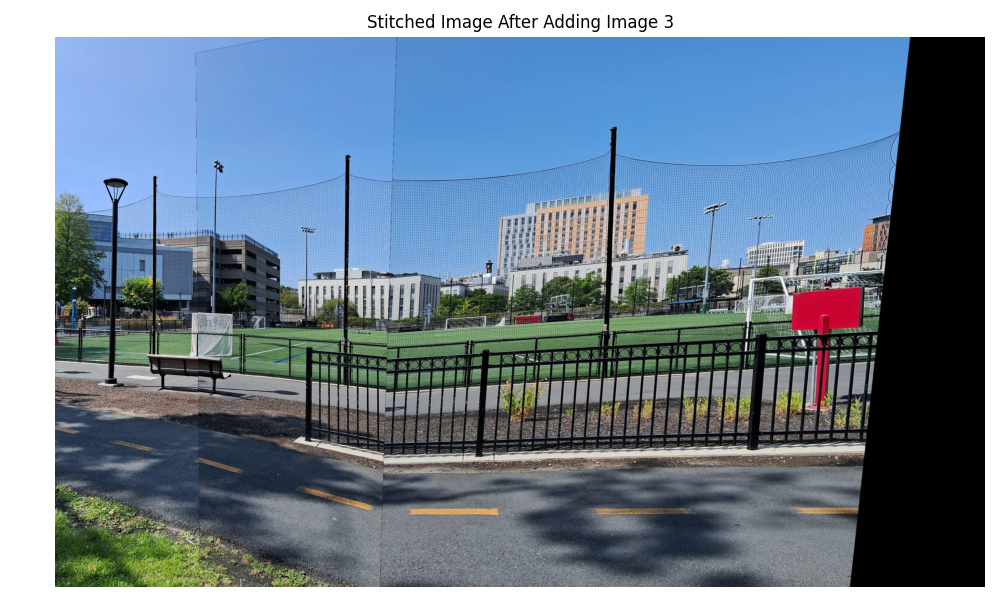
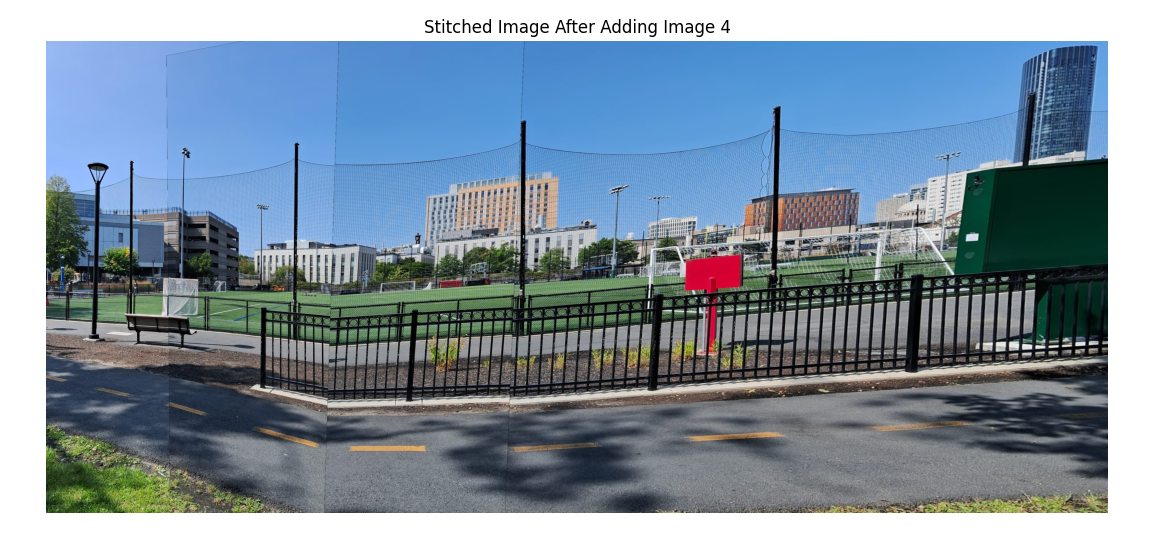

In [37]:
# Function to load images from file paths
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            images.append(img)
            print(f"Loaded {path} successfully.")
        else:
            print(f"Failed to load {path}. Check file path.")
    return images



The images were stitched together successfully, but visible seams were present when using the basic linear blending technique.

In [40]:
# Function to display the final mosaic image
def display_image(image, title="Stitched Image"):
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Main function to load images, stitch them, and display the result
def main():
    image_paths = [
        'E:/AFR/HW2/panoroma/Pimage1.jpg',
        'E:/AFR/HW2/panoroma/Pimage2.jpg',
        'E:/AFR/HW2/panoroma/Pimage3.jpg',
        'E:/AFR/HW2/panoroma/Pimage4.jpg',
        'E:/AFR/HW2/panoroma/Pimage5.jpg'
    ]
    
    images = load_images(image_paths)
    
    if len(images) < 2:
        print("Need at least two images to stitch.")
        return
    
    mosaic = stitch_all_images(images)
    
    display_image(mosaic, title="Final Stitched Mosaic")
    
    output_path = 'E:/AFR/HW2/panoroma/stitched_mosaic.jpg'
    cv2.imwrite(output_path, mosaic)
    print(f"Stitched mosaic saved at {output_path}")

if __name__ == "__main__":
    main()


Loaded E:/AFR/HW2/panoroma/Pimage1.jpg successfully.
Loaded E:/AFR/HW2/panoroma/Pimage2.jpg successfully.
Loaded E:/AFR/HW2/panoroma/Pimage3.jpg successfully.
Loaded E:/AFR/HW2/panoroma/Pimage4.jpg successfully.
Loaded E:/AFR/HW2/panoroma/Pimage5.jpg successfully.
Stitching image 2 to the mosaic...
Homography matrix for image 2 to mosaic:
[[ 8.89052696e-01 -4.89283934e-02  5.38605402e+02]
 [-1.85887945e-01  9.17814552e-01  7.13570717e+01]
 [-1.14689586e-04 -1.40156989e-05  1.00000000e+00]]

Stitching image 3 to the mosaic...
Homography matrix for image 3 to mosaic:
[[ 8.31636611e-01 -1.71107927e-01  1.29639890e+03]
 [-2.97841444e-01  8.59701063e-01  1.31384655e+01]
 [-1.47478012e-04 -6.37449907e-05  1.00000000e+00]]

Stitching image 4 to the mosaic...
Homography matrix for image 4 to mosaic:
[[ 1.03932773e+00  5.12048048e-01  1.84390199e+03]
 [-4.13464602e-01  1.87207228e+00 -7.44617691e+02]
 [-2.43273828e-04  2.57787394e-04  1.00000000e+00]]

Stitching image 5 to the mosaic...
Homogra

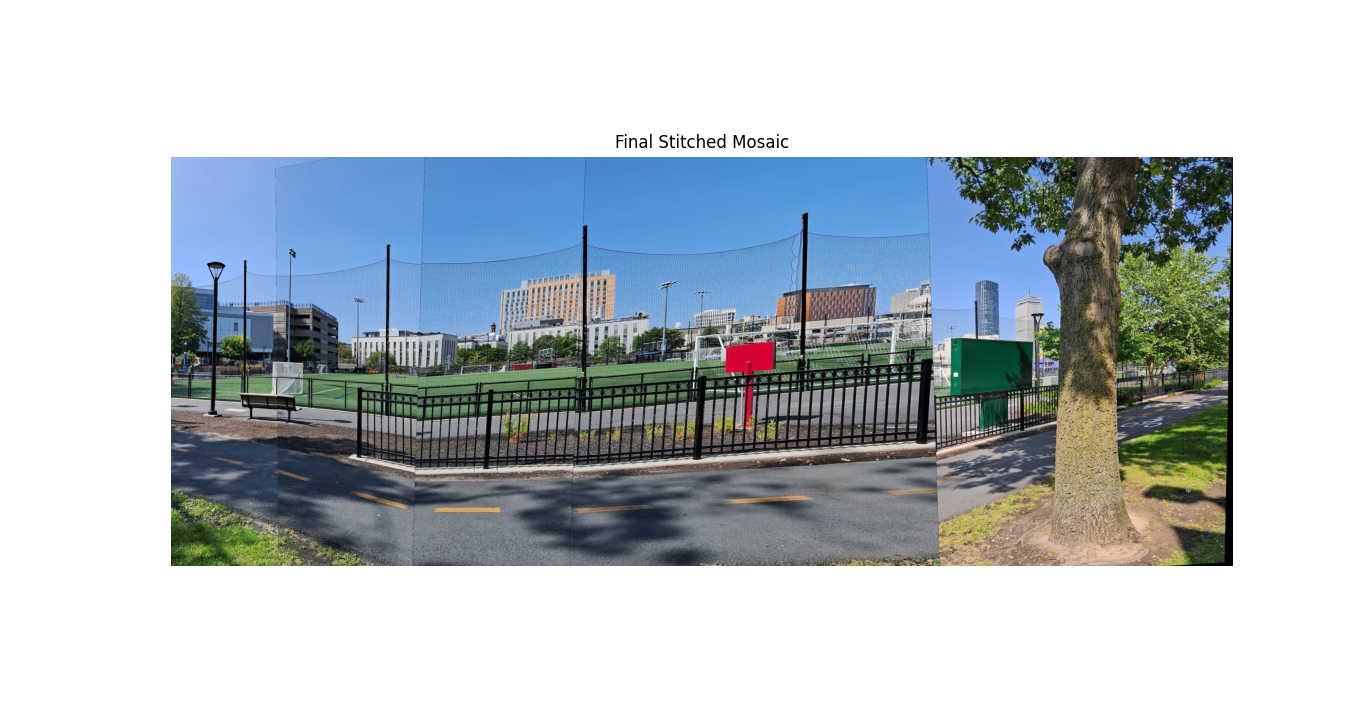

Part 3: Feather blend Technique.

"While the assignment suggested a simple linear blending technique, I experimented with feather blending to enhance the transition between overlapping images. Feather blending uses a blurred mask to gradually blend the overlapping regions, which resulted in a smoother and more seamless mosaic. Given the flexibility in the blending method and the superior results, I opted to use feather blending for the final mosaic."

In [ ]:
def feather_blend(mosaic, warped_img, mask):
    feather_width = 31  # Feathering width must be odd
    mask_blurred = cv2.GaussianBlur(mask, (feather_width, feather_width), 0)
    return mosaic * (1 - mask_blurred) + warped_img * mask_blurred


# Define select_points function (unchanged)
def select_points(image, title='Select four points'):
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    points = plt.ginput(4)
    plt.close()
    return np.array(points, dtype='float32')

# Load images (unchanged)
image_paths = ['panoroma/Pimage1.jpg', 'panoroma/Pimage2.jpg', 'panoroma/Pimage3.jpg', 'panoroma/Pimage4.jpg', 'panoroma/Pimage5.jpg']  # Replace with your image paths
images = [cv2.imread(path) for path in image_paths]

# Verify all images are loaded (unchanged)
for idx, img in enumerate(images):
    if img is None:
        raise IOError(f"Image at path {image_paths[idx]} could not be loaded.")

# Select corresponding points between consecutive images (unchanged)
pts_image1 = select_points(images[0], 'Select four common points in Image1')
pts_image2 = select_points(images[1], 'Select four corresponding points in Image2')

pts_image2_2 = select_points(images[1], 'Select four common points in Image2')
pts_image3 = select_points(images[2], 'Select four corresponding points in Image3')

pts_image3_2 = select_points(images[2], 'Select four common points in Image3')
pts_image4 = select_points(images[3], 'Select four corresponding points in Image4')

pts_image4_2 = select_points(images[3], 'Select four common points in Image4')
pts_image5 = select_points(images[4], 'Select four corresponding points in Image5')

# Compute homographies between consecutive pairs using RANSAC
H_12, status = cv2.findHomography(pts_image2, pts_image1, cv2.RANSAC, 5.0)  # image2 -> image1
H_23, status = cv2.findHomography(pts_image3, pts_image2_2, cv2.RANSAC, 5.0)  # image3 -> image2
H_34, status = cv2.findHomography(pts_image4, pts_image3_2, cv2.RANSAC, 5.0)  # image4 -> image3
H_45, status = cv2.findHomography(pts_image5, pts_image4_2, cv2.RANSAC, 5.0)  # image5 -> image4

# Compose homographies to map all images to image1's coordinate system (unchanged)
H_11 = np.eye(3)
H_21 = H_12
H_31 = H_12 @ H_23
H_41 = H_12 @ H_23 @ H_34
H_51 = H_12 @ H_23 @ H_34 @ H_45

composite_homographies = [H_11, H_21, H_31, H_41, H_51]

# Warp corners to find the size of the mosaic (unchanged)
def warp_corners(image, H):
    h, w = image.shape[:2]
    corners = np.array([
        [0, 0],
        [w, 0],
        [w, h],
        [0, h]
    ], dtype='float32').reshape(-1, 1, 2)
    warped = cv2.perspectiveTransform(corners, H)
    return warped

warped_corners = []
for i in range(len(images)):
    warped = warp_corners(images[i], composite_homographies[i])
    warped_corners.append(warped)

# Find the bounds of the mosaic (unchanged)
all_corners = np.vstack(warped_corners)
[x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
[x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

# Compute translation to shift the mosaic (unchanged)
translation = [-x_min, -y_min]

# Update homographies to include translation (unchanged)
translation_matrix = np.array([
    [1, 0, translation[0]],
    [0, 1, translation[1]],
    [0, 0, 1]
])

for i in range(len(composite_homographies)):
    composite_homographies[i] = translation_matrix @ composite_homographies[i]

# Create the mosaic canvas (unchanged)
mosaic_height = y_max - y_min
mosaic_width = x_max - x_min
mosaic_float = np.zeros((mosaic_height, mosaic_width, 3), dtype='float32')
weight = np.zeros((mosaic_height, mosaic_width, 3), dtype='float32')

# Warp and blend each image onto the mosaic with feathering
for i, img in enumerate(images):
    warped_img = cv2.warpPerspective(img, composite_homographies[i], (mosaic_width, mosaic_height))
    mask = (warped_img > 0).astype(np.float32)
    
    # Use feather blending instead of a hard mask
    mosaic_float = feather_blend(mosaic_float, warped_img, mask)

# Avoid division by zero (unchanged)
weight[weight == 0] = 1.0

# Normalize to get the final mosaic (unchanged)
mosaic_blended = mosaic_float / weight
mosaic_blended = np.clip(mosaic_blended, 0, 255).astype('uint8')

# Convert to RGB for displaying (unchanged)
mosaic_rgb = cv2.cvtColor(mosaic_blended, cv2.COLOR_BGR2RGB)

# Display the mosaic (unchanged)
plt.figure(figsize=(20, 15))
plt.imshow(mosaic_rgb)
plt.title('Stitched Mosaic')
plt.axis('off')
plt.show()


**Differnce in Blending method**

Simple Liner-Weighted average Technique:

Simple linear blending in OpenCV doesn’t separate frequency bands and may result in visible seams or ghosting if images differ in lighting or alignment.


The formula used in this technique is:


                                Blended Image=α⋅Image1+(1−α)⋅Image2


If the images have significant differences in lighting or alignment, this method can produce seams and ghosting artifacts where the images overlap, because there is no handling of different frequency bands or variations in the images.
Simple Blending is computationally light. we just blend two images pixel by pixel using a weighted average, making it faster to implement.


Pyramid Technique: Pyramid blending works on different frequency bands, allowing for more sophisticated blending with fewer visible seams.
The final blended image is obtained by reconstructing the original image from the blended Laplacian pyramid, starting from the coarsest level and progressively adding the detail from each higher level.

Pyramid Blending is more computationally intensive. It requires creating multiple pyramid levels for both images, performing the blending at each level, and then reconstructing the image. However, the result is far superior in quality, especially when blending complex or misaligned images.